### Mark Hoogendoorn and Burkhardt Funk (2017)              
Machine Learning for the Quantified Self               
Springer,
Chapter 7    

In [36]:
from util.VisualizeDataset import VisualizeDataset
from Chapter7.PrepareDatasetForLearning import PrepareDatasetForLearning
from Chapter7.LearningAlgorithms import ClassificationAlgorithms
from Chapter7.LearningAlgorithms import RegressionAlgorithms
from Chapter7.Evaluation import ClassificationEvaluation
from Chapter7.Evaluation import RegressionEvaluation
from Chapter7.FeatureSelection import FeatureSelectionClassification
from Chapter7.FeatureSelection import FeatureSelectionRegression
import copy
import pandas as pd
from util import util
import matplotlib.pyplot as plot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from util import ClassificationReport
import os

In [37]:
DataViz = VisualizeDataset()

# Read the result from the previous chapter, and make sure the index is of the type datetime.
dataset_path = 'intermediate_datafiles/'

export_tree_path = 'Example_graphs/Chapter7/'

try:
    dataset = pd.read_csv(dataset_path + 'chapter5_result.csv', index_col=0)
except IOError as e:
    print('File not found, try to run previous crowdsignals scripts first!')
    raise e

if not os.path.exists(export_tree_path):
    os.makedirs(export_tree_path)

dataset.index = pd.to_datetime(dataset.index, format='%Y-%m-%d %H:%M:%S.%f'[:-3])

In [38]:
# Remove unnecessary columns
del dataset['participant']
del dataset['set']

In [39]:
# Split data according to weight
dataset_heavy = dataset[dataset['category'] == 'heavy']
dataset_medium = dataset[dataset['category'] == 'medium']

In [40]:
# Remove unnecessary columns
del dataset_heavy['category']
del dataset_medium['category']

In [41]:
# We create a single column with the categorical attribute representing our class. Furthermore, we use 70% of our data
# for training and the remaining 30% as an independent test set. We select the sets based on stratified sampling.

prepare = PrepareDatasetForLearning()

train_X, test_X, train_y, test_y = prepare.split_single_dataset_classification(dataset_medium, ['label'], 'like', 0.7, filter=True, temporal=False)

print 'Training set length is: ', len(train_X.index)
print 'Test set length is: ', len(test_X.index)

Training set length is:  1551
Test set length is:  666


In [42]:
# Load algorithms
learner = ClassificationAlgorithms()
eval = ClassificationEvaluation()

In [43]:
# Train a random forest and predict class labels
class_train_y, class_test_y, class_train_prob_y, class_test_prob_y, model = learner.random_forest(train_X, train_y, test_X,
                                                                                           gridsearch=True, print_model_details=True)

{'n_estimators': 100, 'criterion': 'gini', 'min_samples_leaf': 2}
Feature importance random forest:
pca_1  &  0.0899250572774
acc_y_temp_mean_ws_4  &  0.0891472203176
pca_3  &  0.0716042892704
cluster  &  0.0710532392431
pca_2  &  0.0641657115277
acc_z_temp_mean_ws_4  &  0.0641413158825
gyr_z_temp_std_ws_4  &  0.0632600766565
acc_x_temp_mean_ws_4  &  0.062082324262
acc_y  &  0.0578163322069
acc_y_temp_std_ws_4  &  0.0511561853151
acc_z  &  0.0382778180248
acc_x  &  0.0364967930707
acc_x_temp_std_ws_4  &  0.0272213252861
gyr_r_freq_0.0_Hz_ws_4  &  0.0253889677344
gyr_r_temp_std_ws_4  &  0.0235364959004
gyr_r_temp_mean_ws_4  &  0.0221945406563
acc_r_temp_std_ws_4  &  0.0220982217346
gyr_x_temp_std_ws_4  &  0.0187054498551
gyr_z  &  0.0138501601366
acc_z_temp_std_ws_4  &  0.0126632979998
gyr_z_temp_mean_ws_4  &  0.0110024234512
acc_r_freq_0.25_Hz_ws_4  &  0.0069970718911
acc_r_pse  &  0.00677331665031
acc_r_freq_0.0_Hz_ws_4  &  0.00594249223975
gyr_x  &  0.00500998005031
gyr_r  &  0.00450

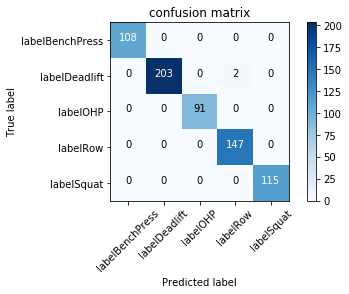

In [44]:
# Performance on the test data of the same weight class
test_cm = eval.confusion_matrix(test_y, class_test_y, class_train_prob_y.columns)
DataViz.plot_confusion_matrix(test_cm, class_train_prob_y.columns, normalize=False)

In [45]:
accuracy_score(test_y, class_test_y)

0.99699699699699695

In [46]:
# Prepare medium weight sets for testing
# For convience, we use the prepare.split_single_dataset_classification again
# but use 95% for the test split
m_train_X, m_test_X, m_train_y, m_test_y = prepare.split_single_dataset_classification(dataset_heavy, ['label'], 'like', 0.05, filter=True, temporal=False)

In [47]:
# Make predictions on the the other weight class using the trained model
pred_prob_training_y = model.predict_proba(m_train_X)
pred_prob_test_y = model.predict_proba(m_test_X)
pred_training_y = model.predict(m_train_X)
pred_test_y = model.predict(m_test_X)
frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=model.classes_)
frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=model.classes_)

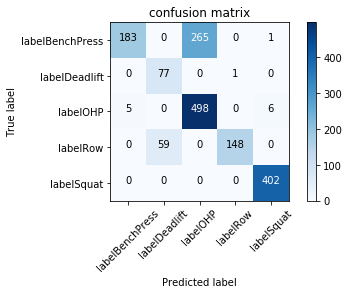

In [48]:
# Performance on the data of the other weight class
test_cm = eval.confusion_matrix(m_test_y, pred_test_y, frame_prob_training_y.columns)
DataViz.plot_confusion_matrix(test_cm, frame_prob_training_y.columns, normalize=False)

In [49]:
accuracy_score(m_test_y, pred_test_y)

0.79513677811550154